In [119]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Test LSTM using minute data

In [120]:
# data = yf.download('BTC-USD', period='2y')
#data = pd.read_csv('./processed_data/BTC_1m_data_indicators.csv')
data = pd.read_csv('./market_data/BTC_1m_data.csv')

In [121]:
# data.index = pd.to_datetime(data.index)
data.set_index('Open Time', inplace = True)

# Create Price Movement column (1 = price increased, 0 = price decreased or unchanged)
# data['Price_Movement'] = (data['Close'].diff() > 0).astype(int)

In [122]:
# data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()

In [123]:
""" macd_indicator = ta.trend.MACD(close=data['Close'].squeeze(), window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd_indicator.macd()  # MACD Line
data['MACD_signal'] = macd_indicator.macd_signal()  # Signal Line
data['MACD_hist'] = macd_indicator.macd_diff()  # Histogram (MACD - Signal) """


" macd_indicator = ta.trend.MACD(close=data['Close'].squeeze(), window_slow=26, window_fast=12, window_sign=9)\ndata['MACD'] = macd_indicator.macd()  # MACD Line\ndata['MACD_signal'] = macd_indicator.macd_signal()  # Signal Line\ndata['MACD_hist'] = macd_indicator.macd_diff()  # Histogram (MACD - Signal) "

In [124]:
data = data['2024-01-01':]

In [125]:
data

,Open,High,Low,Close,Volume,Number of Trades,Coin,MACD,MACD_Signal,MACD_Hist,RSI
Open Time,,,,,,,,,,,
2024-12-31 16:00:00,95412.00,95454.55,95308.00,95308.01,15.17924,4110,BTC,95308.010000,95308.010000,0.000000,95308.010000
2024-12-31 16:01:00,95308.01,95386.03,95291.66,95361.49,17.54599,3991,BTC,95316.237692,95318.706000,-2.468308,95334.750000
2024-12-31 16:02:00,95361.48,95373.81,95320.27,95352.26,10.70271,2292,BTC,95321.779586,95325.416800,-3.637214,95340.586667
2024-12-31 16:03:00,95352.26,95364.48,95250.00,95258.62,11.82793,4267,BTC,95312.062726,95312.057440,0.005286,95320.095000
2024-12-31 16:04:00,95258.61,95304.37,95201.78,95272.29,19.69380,5153,BTC,95305.943845,95304.103952,1.839893,95310.534000
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 15:56:00,83879.52,83912.49,83800.00,83800.01,61.60958,7231,BTC,57.714012,87.959848,-30.245836,46.766248
2025-02-28 15:57:00,83800.01,83888.29,83768.53,83849.54,46.47085,7604,BTC,46.117191,79.591316,-33.474126,48.929368
2025-02-28 15:58:00,83849.54,83947.75,83849.54,83947.75,30.48454,6875,BTC,44.340226,72.541098,-28.200872,53.006920


In [126]:
sequence_length = 60
train_size = 0.8
# Extract feature column and convert to numpy array
dataset = data['Close'].values.reshape(-1, 1)

# Store corresponding dates for later reference
dates = data.index

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create sequences
X, y, sequence_dates = [], [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length, 0])
    y.append(scaled_data[i+sequence_length, 0])
    # Store the date corresponding to the target (y) value
    sequence_dates.append(dates[i+sequence_length])

X, y = np.array(X), np.array(y)

# Reshape X to 3D format expected by LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets
train_size = int(len(X) * train_size)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_dates = sequence_dates[:train_size]
test_dates = sequence_dates[train_size:]

In [127]:
units=50
dropout=0.2
layers=1

model = Sequential()
    
# First LSTM layer
if layers == 1:
    model.add(LSTM(units=units, input_shape=(sequence_length, 1)))
else:
    model.add(LSTM(units=units, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(dropout))
    
    # Additional LSTM layers
    for i in range(layers-2):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout))
    
    # Final LSTM layer
    model.add(LSTM(units=units))

model.add(Dropout(dropout))
model.add(Dense(units=1))  # Output layer

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/linyan/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0134 - val_loss: 2.4329e-05
Epoch 2/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0014 - val_loss: 1.3866e-05
Epoch 3/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 5.0262e-04 - val_loss: 9.6343e-06
Epoch 4/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.6656e-04 - val_loss: 8.4102e-06
Epoch 5/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.1237e-04 - val_loss: 2.9672e-05
Epoch 6/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.1308e-04 - val_loss: 6.0810e-06
Epoch 7/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.0917e-04 - val_loss: 6.2808e-06
Epoch 8/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.1043e-04 - val_loss: 3.0383e-05
Epoch 9/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.1018e-04 - val_loss: 5.6633e-06
Epoch 10/50
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.0748e-04 - val_loss: 1.9988e-05
Epoch 11/50
1911/1911 ━━━━━━━━━━━━━━━

In [129]:
#Reshape predictions for inverse transform
train_predictions = train_predictions.reshape(-1, 1)
test_predictions = test_predictions.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Inverse transform
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
train_actual = scaler.inverse_transform(y_train)
test_actual = scaler.inverse_transform(y_test)

In [130]:
train_mse = mean_squared_error(train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_actual, train_predictions)

test_mse = mean_squared_error(test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_actual, test_predictions)

train_mape = np.mean(np.abs((train_actual - train_predictions) / train_actual)) * 100
test_mape = np.mean(np.abs((test_actual - test_predictions) / test_actual)) * 100

Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1023 ticks ([-4202.0, ..., 89119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

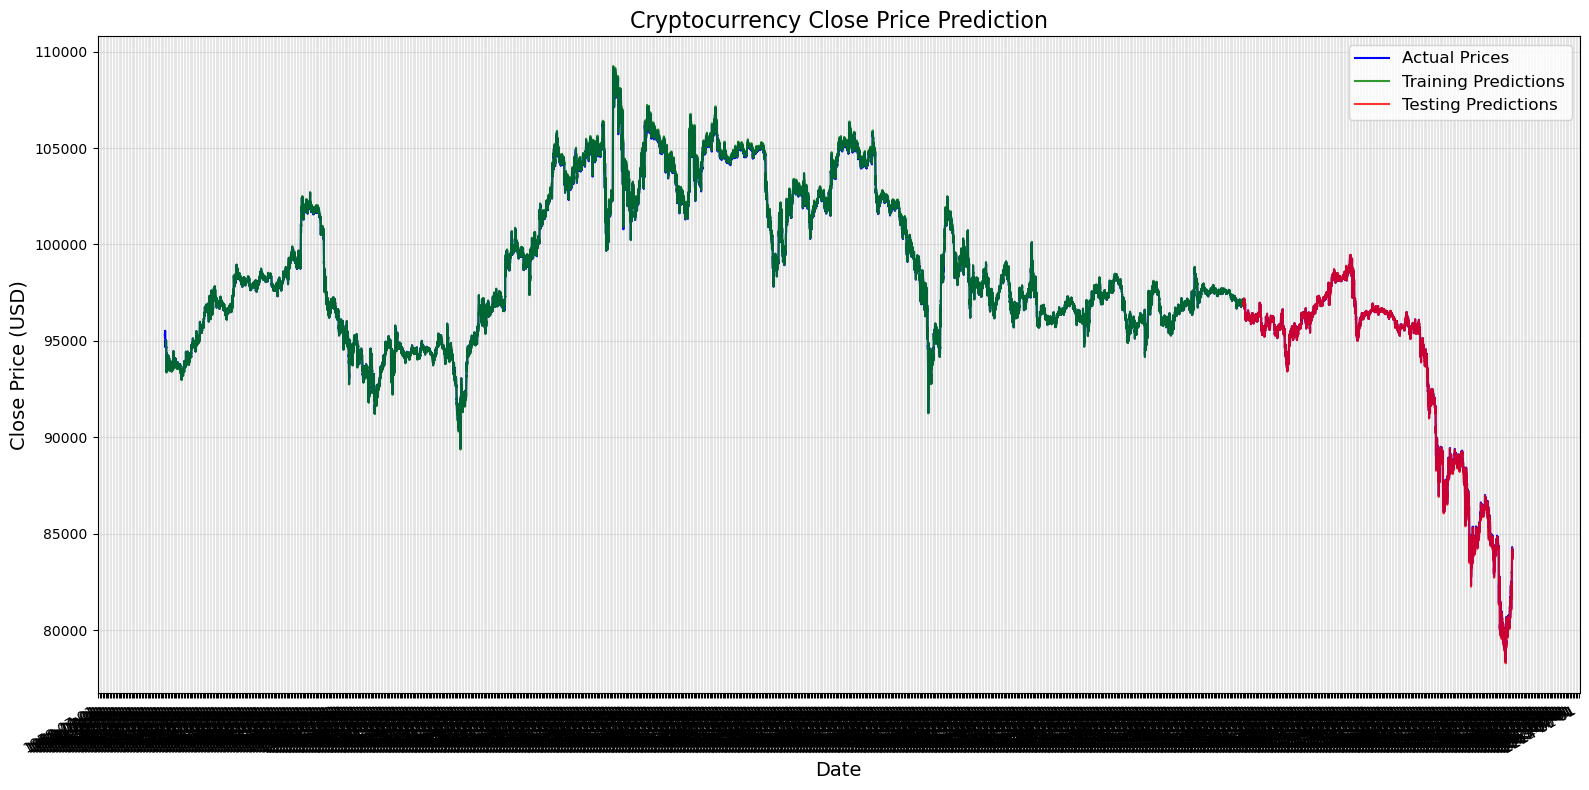

In [131]:
feature = 'Close' 
# Create figure
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(data.index, data[feature], label='Actual Prices', color='blue')

# Plot predictions
plt.plot(train_dates, train_predictions, label='Training Predictions', color='green', alpha=0.8)
plt.plot(test_dates, test_predictions, label='Testing Predictions', color='red', alpha=0.8)

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add grid, labels and legend
plt.grid(True, alpha=0.3)
plt.title(f'Cryptocurrency {feature} Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{feature} Price (USD)', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [139]:
print(train_mse)
print(train_rmse)
print(train_mae)

6773.578633263282
82.3017535248386
54.014454721547494


In [140]:
print(test_mse)
print(test_rmse)
print(test_mae)

5592.116984270463
74.78045857221299
47.86921774704094


In [141]:
print(train_mape)
print(test_mape)

0.0541203588038694
0.05322041610984022


In [135]:
""" sequence_length = 60
train_size = 0.8
dataset = data['Price_Movement'].values.reshape(-1, 1)
dates = data.index

# No need to scale binary classification labels (0 or 1)

# Create sequences
X, y, sequence_dates = [], [], []
for i in range(len(dataset) - sequence_length):
    X.append(dataset[i:i+sequence_length, 0])
    y.append(dataset[i+sequence_length, 0])
    sequence_dates.append(dates[i+sequence_length])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Split into training and testing sets
train_size = int(len(X) * train_size)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_dates = sequence_dates[:train_size]
test_dates = sequence_dates[train_size:] """

" sequence_length = 60\ntrain_size = 0.8\ndataset = data['Price_Movement'].values.reshape(-1, 1)\ndates = data.index\n\n# No need to scale binary classification labels (0 or 1)\n\n# Create sequences\nX, y, sequence_dates = [], [], []\nfor i in range(len(dataset) - sequence_length):\n    X.append(dataset[i:i+sequence_length, 0])\n    y.append(dataset[i+sequence_length, 0])\n    sequence_dates.append(dates[i+sequence_length])\n\nX, y = np.array(X), np.array(y)\nX = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM\n\n# Split into training and testing sets\ntrain_size = int(len(X) * train_size)\nX_train, X_test = X[:train_size], X[train_size:]\ny_train, y_test = y[:train_size], y[train_size:]\ntrain_dates = sequence_dates[:train_size]\ntest_dates = sequence_dates[train_size:] "

In [136]:
""" sequence_legnth = 60
units=50
dropout=0.2
layers=1

model = Sequential()

if layers == 1:
    model.add(LSTM(units=units, input_shape=(sequence_length, 1)))
else:
    model.add(LSTM(units=units, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(dropout))
    
    for _ in range(layers - 2):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout))
    
    model.add(LSTM(units=units))

model.add(Dropout(dropout))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) """

" sequence_legnth = 60\nunits=50\ndropout=0.2\nlayers=1\n\nmodel = Sequential()\n\nif layers == 1:\n    model.add(LSTM(units=units, input_shape=(sequence_length, 1)))\nelse:\n    model.add(LSTM(units=units, return_sequences=True, input_shape=(sequence_length, 1)))\n    model.add(Dropout(dropout))\n    \n    for _ in range(layers - 2):\n        model.add(LSTM(units=units, return_sequences=True))\n        model.add(Dropout(dropout))\n    \n    model.add(LSTM(units=units))\n\nmodel.add(Dropout(dropout))\nmodel.add(Dense(units=1, activation='sigmoid'))  # Binary classification\n \nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) "

In [137]:
""" early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

train_predictions = (model.predict(X_train) > 0.5).astype(int)
test_predictions = (model.predict(X_test) > 0.5).astype(int) """

" early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)\n\nhistory = model.fit(\n    X_train, y_train,\n    epochs=50,\n    batch_size=32,\n    validation_split=0.1,\n    callbacks=[early_stop],\n    verbose=1\n)\n\ntrain_predictions = (model.predict(X_train) > 0.5).astype(int)\ntest_predictions = (model.predict(X_test) > 0.5).astype(int) "

In [138]:
""" train_acc = np.mean(train_predictions == y_train)
test_acc = np.mean(test_predictions == y_test)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}") """

' train_acc = np.mean(train_predictions == y_train)\ntest_acc = np.mean(test_predictions == y_test)\n\nprint(f"Training Accuracy: {train_acc:.2f}")\nprint(f"Testing Accuracy: {test_acc:.2f}") '